<a href="https://colab.research.google.com/github/goyalmayank522/Face-Mask-Detection/blob/main/Face_Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Mask Detector**

The dataset consists of 1376 images with 690 images containing images of people wearing masks and 686 images with people without masks.

This dataset is for people who want to try learning techniques of deep learning for face mask detection.The dataset can be downloaded from https://data-flair.training/blogs/download-face-mask-data/

*   **Mounting google drive in colab**
*   **Importing os and shutil to operate with file objects easily**



In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os, shutil

Mounted at /content/drive


The dataset is stored in the local drive. The training dataset is present in train directory & testing dataset is present in test directory.

### **Path to dataset having testing and training folder** 

In [ ]:
original_dataset_dir='/content/drive/MyDrive/Face_mask_detector/Dataset'

### **Path to the training and testing directory**

In [ ]:
train_dir='/content/drive/MyDrive/Face_mask_detector/Dataset/train'
test_dir='/content/drive/MyDrive/Face_mask_detector/Dataset/test'

### **Path to sub-folder with_mask and without_mask of training and testing directory**

In [ ]:
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')

### **Showing total number of training and testing images**

In [ ]:
print('Total training with_mask images:', len(os.listdir(train_with_mask_dir)))
print('Total training without_mask images:', len(os.listdir(train_without_mask_dir)))
print('Total testing with_mask images:', len(os.listdir(test_with_mask_dir)))
print('Total testing without_mask images:', len(os.listdir(test_without_mask_dir)))

Total training with_mask images: 658
Total training without_mask images: 657
Total testing with_mask images: 97
Total testing without_mask images: 97


# **Building the network**

## **Instantiating a small convnet for face mask detector**

Firstly, Importing the keras framework which is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.

Then the following layers are imported from the keras layers:

*   **Conv2D layer:** It has a filter or a kernel which “slides” over the 2D input data, performing an elementwise multiplication which results as a single output pixel.
*   **MaxPooling2D layer:** It downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the feature axis & the window is shifted by strides in each dimension.
*   **Flatten layer:** It converts the pooled feature map to a single column that is passed to the fully connected layer. It never affects the batch size.
*   **Dense layer:** It is a fully connected layer in which all the neurons in a layer are connected to those in the next layer.

In [ ]:
import keras
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from keras.models import Sequential

Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer. Here, the sequential model is defined and the above mentioned layers are added to the model.

The below mentioned arguements are involved in the first Conv2D layer :

*   **filters :** It represents the number of output filters in the convolution. Here, the filter size is 32.
*   **kernel_size :** It specifies the height and width of the 2D convolution window. Here, the kernel_size is (3,3).
*   **activation function :** Here, the Relu activation function is used which is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
*   **input_shape :** The height, width & depth of the input image is 150, 150 & 3 respectively.


In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

## **The summary of created model**

***Let’s look at how the dimensions of the feature maps change with every successive layer:***


In the first MaxPooling2D layer, the pool_size is (2,2) and the stride (shifting of window in each dimension) is 1 means it will take maximum value over the window size of (2,2). So, the output shape of this layer is (74,74,32) where 32 is the filter size. This process remain same for all the MaxPooling layers.


The flatten layer flattens the input shape of (17,17,32) to a single column of size (9248) which is then passed to the fully connected dense layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0

# **Configuring the model for training**

For the compilation step, we will go with the Adam optimizer. Because you ended the network with a one sigmoid unit, we will use biniary crossentropy as the loss

In [ ]:
from keras.optimizers import Adam

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# **Data preprocessing**



## **Using ImageDataGenerator to read images from directories**

Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:


1.   Read the picture files.
2.   Decode the JPEG content to RGB grids of pixels.
3.   Convert these into floating-point tensors.
4.   Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as we know, neural networks prefer to deal with small input values).

We'll use ImageDataGenerator from Keras for this purpose. We are creating train generator and test generator which will receive images from train directory and test directory respectively.


As we are having a small number of training images in the dataset so there may be a chance of overfitting.
Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit.

**Data augmentation** takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance.

**Setting up a data augmentation configuration via ImageDataGenerator**

This is real-time data augmentation. In this operation,  the model will receive a new set of input image which will not be seen earlier in the previous epoch. In next epoch a new augmented version of input image is generated and model is trained on it.

Let’s quickly go over this code:

**rotation_range** is a value in degrees (0–180), a range within which to randomly rotate pictures.

**shear_range** is for randomly applying shearing transformations.

**zoom_range** is for randomly zooming inside pictures.

**horizontal_flip** is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example, real-world pictures).

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,shear_range=0.2,zoom_range=0.2,horizontal_flip=True) 
test_datagen = ImageDataGenerator(rescale=1./255)



The batch size is set to 16 means images are grouped into a batch of 16 and will flow from train directory to train generator. The target size is 150 * 150 and class mode is binary.

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=16,class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=16, class_mode='binary')

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


There are 16 samples in each batch (the batch size). 

**Note**: The generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point:

In [ ]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (16, 150, 150, 3)
labels batch shape: (16,)


## **Calculating hyper parameter steps per epoch value and validation step value.**

It is calculated as total files divided by batch size.

In [ ]:
import numpy as np
nb_train_steps = int(np.ceil(len(os.listdir(train_with_mask_dir) + os.listdir(train_without_mask_dir))/16))
print(nb_train_steps)
nb_test_steps = int(np.ceil(len(os.listdir(test_with_mask_dir) + os.listdir(test_without_mask_dir))/16))
print(nb_test_steps)

83
13


# **Fitting the model using a batch generator**

Let’s fit the model to the data using the generator. You do so using the fit_generator method, the equivalent of fit for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over.

This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps—the fitting process will go to the next epoch. In this case, batches have 16 samples, so it will take 83 batches until you see your target of 1315 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(train_generator,steps_per_epoch=nb_train_steps,epochs=50,validation_data=test_generator,validation_steps=nb_test_steps,callbacks=[callback])

Epoch 1/50
83/83 [==============================] - 310s 3s/step - loss: 0.7114 - accuracy: 0.5858 - val_loss: 0.1609 - val_accuracy: 0.9330
Epoch 2/50
83/83 [==============================] - 14s 168ms/step - loss: 0.1369 - accuracy: 0.9614 - val_loss: 0.1167 - val_accuracy: 0.9485
Epoch 3/50
83/83 [==============================] - 14s 169ms/step - loss: 0.1402 - accuracy: 0.9541 - val_loss: 0.1409 - val_accuracy: 0.9485
Epoch 4/50
83/83 [==============================] - 14s 168ms/step - loss: 0.1615 - accuracy: 0.9319 - val_loss: 0.0974 - val_accuracy: 0.9639
Epoch 5/50
83/83 [==============================] - 14s 167ms/step - loss: 0.1138 - accuracy: 0.9561 - val_loss: 0.0793 - val_accuracy: 0.9794
Epoch 6/50
83/83 [==============================] - 14s 165ms/step - loss: 0.0894 - accuracy: 0.9657 - val_loss: 0.0598 - val_accuracy: 0.9845
Epoch 7/50
83/83 [==============================] - 14s 169ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.0702 - val_accuracy: 0.9794
E

In [ ]:
valid_loss, valid_acc = model.evaluate(test_generator, steps=nb_test_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")
loss, acc = model.evaluate(train_generator, steps=nb_train_steps)
print(f"Final training accuracy: {acc*100:.2f}%")

13/13 [==============================] - 1s 52ms/step - loss: 0.0790 - accuracy: 0.9794
Final validation accuracy: 97.94%
83/83 [==============================] - 12s 150ms/step - loss: 0.0425 - accuracy: 0.9840
Final training accuracy: 98.40%


# **Displaying curves of loss and accuracy during training**

In [ ]:
def create_plots(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

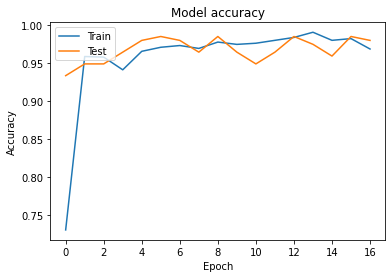

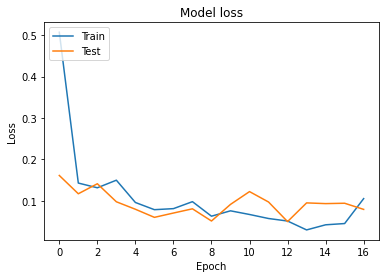

In [ ]:
import matplotlib.pyplot as plt
create_plots(history) 

Here, we can see that the difference between accuracy loss and validation loss is not much high. This may be due to the augmentation operation.

#**Saving the model**

In [ ]:
model.save('/content/drive/MyDrive/Face_mask_detector/final_face_mask_detector9.h5',history)

After saving the model we can re-load it as shown.

In [ ]:
from keras.models import load_model

my_model=load_model('/content/drive/MyDrive/Face_mask_detector/final_face_mask_detector9.h5')

# **For testing on Individual Images**


In [ ]:
import numpy as np
def wear_or_not(image_loc):
  test_image=image.load_img(image_loc,target_size=(150,150,3))
  temp=test_image
  test_image=image.img_to_array(test_image)
  test_image=np.expand_dims(test_image,axis=0)
  pred=my_model.predict(test_image)[0][0]
  if pred==0:
    print("Great! You are wearing a mask.")
  else:
    print("Stop!! Wear a Mask.")
  plt.imshow(temp)
  plt.show()

Reading images from the drive for the testing purpose...

Stop!! Wear a Mask.


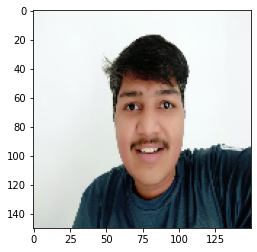

Great! You are wearing a mask.


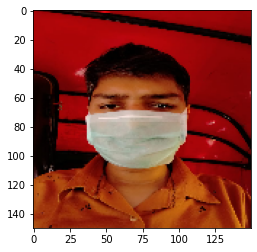

Stop!! Wear a Mask.


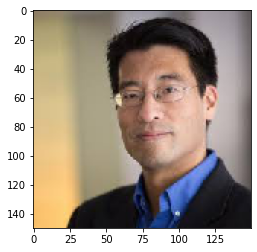

Great! You are wearing a mask.


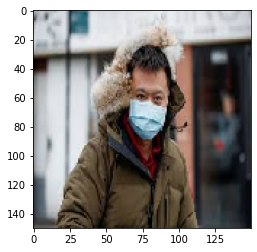

Great! You are wearing a mask.


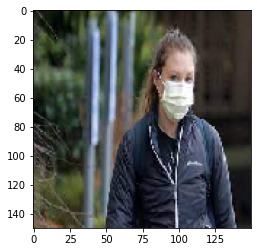

Great! You are wearing a mask.


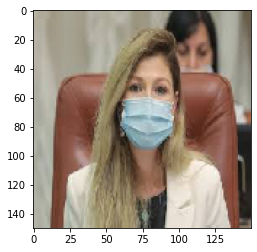

Great! You are wearing a mask.


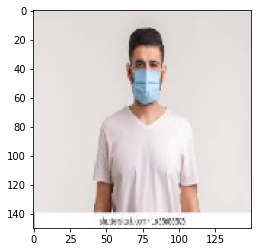

In [ ]:
from keras.preprocessing import image
image_loc1='/content/drive/MyDrive/Face_mask_detector/Dataset/me_without_mask.jpeg'
wear_or_not(image_loc1)
image_loc2='/content/drive/MyDrive/Face_mask_detector/Dataset/me_with_mask.jpeg'
wear_or_not(image_loc2)
image_loc4='/content/drive/MyDrive/Face_mask_detector/Dataset/66.jpg'
wear_or_not(image_loc4)
image_loc5='/content/drive/MyDrive/Face_mask_detector/Dataset/77.jpg'
wear_or_not(image_loc5)
image_loc6='/content/drive/MyDrive/Face_mask_detector/Dataset/88.jpg'
wear_or_not(image_loc6)
image_loc7='/content/drive/MyDrive/Face_mask_detector/Dataset/99.jpg'
wear_or_not(image_loc7)
image_loc8='/content/drive/MyDrive/Face_mask_detector/Dataset/33.jpg'
wear_or_not(image_loc8)

# **For Testing on Group Images**

In [ ]:
import cv2
import dlib
import os
import sys
import glob
import numpy as np
from imutils import face_utils
import skimage.io as io

Following steps are used for detecting face masks in group images-

*   Firstly, all the faces (present in image) coordinates are extracted from the input group image using the OpenCV inbuilt CascadeClassifier.
*   Then, the each face is passed through the trained model to predict whether the face is masked or not.
*   Finally, a bounding box is created around each face according to the prediction made.


In [ ]:
def creating_bounding_box(img_path):
  img = cv2.imread(img_path)
  faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for (x, y, w, h) in faces: 
    temp_img=img[y:y+h,x:x+w]
    temp_img=cv2.resize(temp_img,(150,150),interpolation=cv2.INTER_LINEAR)
    temp_img=image.img_to_array(temp_img)
    temp_img=np.expand_dims(temp_img,axis=0)
    pred=my_model.predict(temp_img)[0][0]
    # plt.figure(figsize=(3,3))
    # plt.imshow(temp_img)
    # plt.show()
    if pred==1:
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
      cv2.putText(img,'NO MASK',(x,y-10),cv2.FONT_HERSHEY_DUPLEX,0.9,(255,0,0),2)
    else:
      cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
      cv2.putText(img,'MASK',(x,y-10),cv2.FONT_HERSHEY_DUPLEX,0.9,(0,255,0),2)
  # plt.figure(figsize=(4,4))
  plt.imshow(img)
  plt.show()

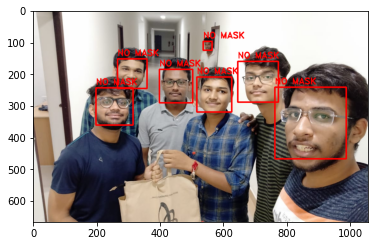

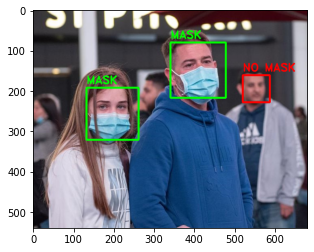

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
img_path2='/content/drive/MyDrive/Face_mask_detector/Dataset/group_img.jpeg'
creating_bounding_box(img_path2)
img_path3='/content/drive/MyDrive/Face_mask_detector/Dataset/grp12.jpg'
creating_bounding_box(img_path3)

Finally, we tested on some random group images taken from the internet and the predictions of the model is shown above.

We can clearly see that in the 1st image, among all the seven persons present in the image, no one is wearing a face mask and the described model is also predicting the same.

Also in the 2nd image, total three persons are visible and among those two are wearing & one is not wearing the face mask. Our model has also created the correct bounding boxes around their faces.
